# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [2]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import dotenv

# create your own .env file and add in your directory in the format
# SKU_DATASET_DIR = r"your_directory"
# dotenv.load_dotenv()
# SKU_DATASET_DIR = os.getenv("SKU_DATASET_DIR")
sku_dataset_dir = r"C:\Users\Bloom\OneDrive\Documents\GitHub\term7cv\SKU110K_fixed"
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.9.1
GPU Available: []


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [3]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [4]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

## Load data

In [5]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)
print(len(train_data))

189


## Visualise data

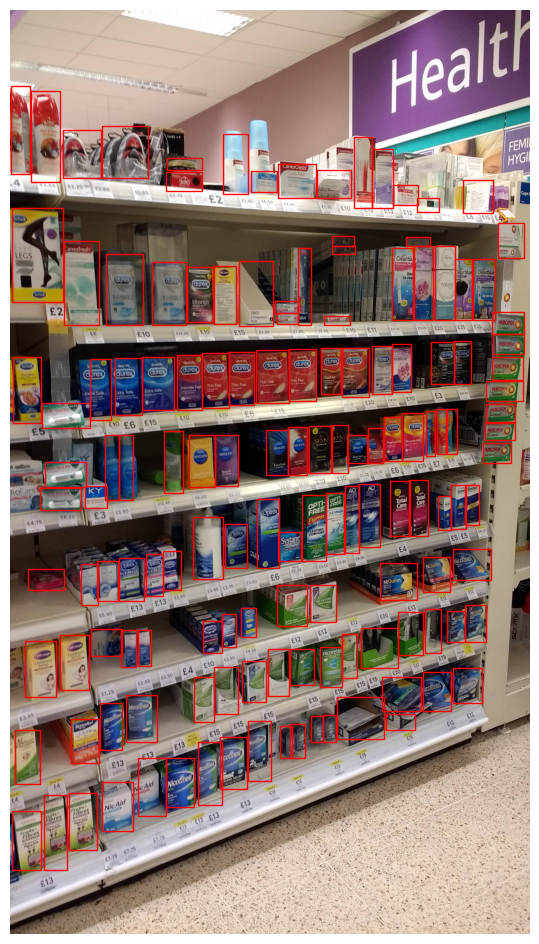

In [6]:
data_num, set = 10, 'test' 
image_num = sku_dataset_dir + rf'\images\{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv("C:/Users/Bloom/OneDrive/Documents/GitHub/term7cv/SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Train

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception, VGG19, ResNet50V2, InceptionV3, InceptionResNetV2, MobileNetV2, EfficientNetB2, VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

## Pipeline for Multimodel Testing

In [12]:
modelsList_1 = {
    "Xception": Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG19": VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50V2": ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
}

modelList_2 = {
    # "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB2": EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

modelList_3 = {
    "ResNet50V2": ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "VGG16": VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

94765736/94765736 [==============================] - 6s 0us/step


In [8]:
for modelname, base_model in modelsList_1.items():
    iou = tf.keras.metrics.MeanIoU(num_classes=2) 

    base_model.trainable = False
    model = models.Sequential([
        Input(shape=(416, 233, 3)), 
        preprocessing.Resizing(224, 224, interpolation='bilinear'),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
    )
    history = model.fit(train_data, epochs=5, validation_data=val_data)
    model.save(f"{modelname}.keras")
    eval_results = model.evaluate(val_data)
    print(f"Loss on validation data for {modelname}:", eval_results)

    predictions = model.predict(val_data)

    for images, true_boxes in val_data:
        # Get model predictions
        pred_boxes = model.predict(images)
        # Update IoU metric
        iou.update_state(true_boxes, pred_boxes)

    # Get the final IoU
    average_iou = iou.result().numpy()
    print(f'Average IoU for {modelname}: {average_iou}')

Epoch 1/5
189/189 [==============================] - 1757s 9s/step - loss: 7.3449 - auc: 0.4481 - precision: 0.9961 - recall: 0.7524 - val_loss: 7.3358 - val_auc: 0.4372 - val_precision: 0.9948 - val_recall: 0.7494
Epoch 2/5
189/189 [==============================] - 1703s 9s/step - loss: 7.3613 - auc: 0.4533 - precision: 0.9961 - recall: 0.7499 - val_loss: 7.3358 - val_auc: 0.4372 - val_precision: 0.9948 - val_recall: 0.7494
Epoch 3/5
189/189 [==============================] - 1708s 9s/step - loss: 7.3611 - auc: 0.4532 - precision: 0.9961 - recall: 0.7498 - val_loss: 7.3358 - val_auc: 0.4372 - val_precision: 0.9948 - val_recall: 0.7494
Epoch 4/5
189/189 [==============================] - 1842s 10s/step - loss: 7.3619 - auc: 0.4533 - precision: 0.9961 - recall: 0.7499 - val_loss: 7.3358 - val_auc: 0.4372 - val_precision: 0.9948 - val_recall: 0.7494
Epoch 5/5
15/15 [==============================] - 120s 8s/step - loss: 7.3319 - auc: 0.4347 - precision: 0.9948 - recall: 0.7445
Loss on v

In [9]:
for modelname, base_model in modelList_2.items():
    iou = tf.keras.metrics.MeanIoU(num_classes=2) 
    
    base_model.trainable = False
    model = models.Sequential([
        Input(shape=(416, 233, 3)), 
        preprocessing.Resizing(224, 224, interpolation='bilinear'),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
    )
    history = model.fit(train_data, epochs=5, validation_data=val_data)
    model.save(f"{modelname}.keras")
    eval_results = model.evaluate(val_data)
    print(f"Loss on validation data for {modelname}:", eval_results)

    predictions = model.predict(val_data)

    for images, true_boxes in val_data:
        # Get model predictions
        pred_boxes = model.predict(images)
        # Update IoU metric
        iou.update_state(true_boxes, pred_boxes)

    # Get the final IoU
    average_iou = iou.result().numpy()
    print(f'Average IoU for {modelname}: {average_iou}')

Epoch 1/5
189/189 [==============================] - 725s 4s/step - loss: 7.2585 - auc_3: 0.7418 - precision_3: 0.9997 - recall_3: 0.5255 - val_loss: 7.2577 - val_auc_3: 0.7511 - val_precision_3: 1.0000 - val_recall_3: 0.5022
Epoch 2/5
189/189 [==============================] - 715s 4s/step - loss: 7.2433 - auc_3: 0.7508 - precision_3: 1.0000 - recall_3: 0.5016 - val_loss: 7.2577 - val_auc_3: 0.7511 - val_precision_3: 1.0000 - val_recall_3: 0.5022
Epoch 3/5
189/189 [==============================] - 725s 4s/step - loss: 7.2510 - auc_3: 0.7406 - precision_3: 0.9998 - recall_3: 0.5113 - val_loss: 7.2577 - val_auc_3: 0.7511 - val_precision_3: 1.0000 - val_recall_3: 0.5022
Epoch 4/5
189/189 [==============================] - 724s 4s/step - loss: 7.2560 - auc_3: 0.7283 - precision_3: 0.9996 - recall_3: 0.5168 - val_loss: 7.2577 - val_auc_3: 0.7511 - val_precision_3: 1.0000 - val_recall_3: 0.5022
Epoch 5/5
15/15 [==============================] - 50s 3s/step - loss: 7.5169 - auc_3: 0.6256 - 

In [10]:
for modelname, base_model in modelList_3.items():
    iou = tf.keras.metrics.MeanIoU(num_classes=2) 
    
    base_model.trainable = False
    model = models.Sequential([
        Input(shape=(416, 233, 3)), 
        preprocessing.Resizing(224, 224, interpolation='bilinear'),
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
    )
    history = model.fit(train_data, epochs=5, validation_data=val_data)
    model.save(f"{modelname}.keras")
    eval_results = model.evaluate(val_data)
    print(f"Loss on validation data for {modelname}:", eval_results)

    predictions = model.predict(val_data)

    for images, true_boxes in val_data:
        # Get model predictions
        pred_boxes = model.predict(images)
        # Update IoU metric
        iou.update_state(true_boxes, pred_boxes)

    # Get the final IoU
    average_iou = iou.result().numpy()
    print(f'Average IoU for {modelname}: {average_iou}')

Epoch 1/5
189/189 [==============================] - 1253s 7s/step - loss: 0.7411 - auc: 0.5867 - precision: 0.9975 - recall: 0.5277 - val_loss: 0.7234 - val_auc: 0.7135 - val_precision: 1.0000 - val_recall: 0.0300
Epoch 2/5
189/189 [==============================] - 1225s 6s/step - loss: 0.7050 - auc: 0.5931 - precision: 0.9975 - recall: 0.5359 - val_loss: 0.7149 - val_auc: 0.7772 - val_precision: 1.0000 - val_recall: 0.1579
Epoch 3/5
189/189 [==============================] - 1217s 6s/step - loss: 0.6956 - auc: 0.6659 - precision: 0.9984 - recall: 0.5454 - val_loss: 0.7075 - val_auc: 0.7914 - val_precision: 1.0000 - val_recall: 0.5425
Epoch 4/5
189/189 [==============================] - 1224s 6s/step - loss: 0.6926 - auc: 0.7061 - precision: 0.9992 - recall: 0.5480 - val_loss: 0.7078 - val_auc: 0.7312 - val_precision: 1.0000 - val_recall: 0.4856
Epoch 5/5
15/15 [==============================] - 86s 6s/step - loss: 0.7073 - auc: 0.7009 - precision: 0.9995 - recall: 0.5602
Loss on val

In [13]:
import keras.utils as image
from tensorflow.keras.models import load_model

img_path = "SKU110K_fixed/images/test_10.jpg"
img = image.load_img(img_path, target_size=(416, 233))  # Adjust target_size based on the VGG19 input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

model = load_model('EfficientNetB2.keras')
predictions = model.predict(val_data)

print(predictions)

for images, true_boxes in val_data:
    # Get model predictions
    pred_boxes = model.predict(images)
    print("boxes:", pred_boxes)
    # Update IoU metric
    # iou.update_state(true_boxes, pred_boxes)

# # Visualize the results (this is a simple example, adapt as needed)
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle

# # Load the original image for visualization
# original_img = image.load_img(img_path)

# # Create a figure and axes
# fig, ax = plt.subplots(1)

# # Display the original image
# ax.imshow(original_img)

# # Extract bounding box information from predictions and draw rectangles
# # Adapt this based on your model's output format
# for prediction in predictions:
#     x, y, width, height = get_bounding_box_coordinates(prediction)  # Implement a function to get coordinates
#     rect = Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

# plt.show()


15/15 [==============================] - 97s 6s/step
[[0.46396324 0.36791015 0.5352545  0.41390845]
 [0.60893315 0.49505818 0.6708765  0.5328537 ]
 [0.40128657 0.33494836 0.49870336 0.36522326]
 ...
 [0.4331119  0.44532377 0.49538    0.48605675]
 [0.56277585 0.60299766 0.60315067 0.65914243]
 [0.5081484  0.4740507  0.5543924  0.52333224]]
2/2 [==============================] - 9s 2s/step
boxes: [[0.46396333 0.36791024 0.5352544  0.41390845]
 [0.60893315 0.4950581  0.6708765  0.53285366]
 [0.40128672 0.3349484  0.49870348 0.36522323]
 [0.4762998  0.43063012 0.5453182  0.47285357]
 [0.43193984 0.47312978 0.5172974  0.5008224 ]
 [0.3786197  0.4316663  0.45695913 0.47515315]
 [0.44275954 0.43913937 0.483463   0.4896013 ]
 [0.43852085 0.4408065  0.44706637 0.5066068 ]
 [0.43852085 0.4408065  0.44706637 0.5066068 ]
 [0.5041118  0.5788859  0.5421136  0.6296786 ]
 [0.36092767 0.47960344 0.37984228 0.5346902 ]
 [0.37432435 0.534455   0.37271234 0.5919148 ]
 [0.46868476 0.46448606 0.52050155 0.5

TypeError: unsupported operand type(s) for -: 'str' and 'str'

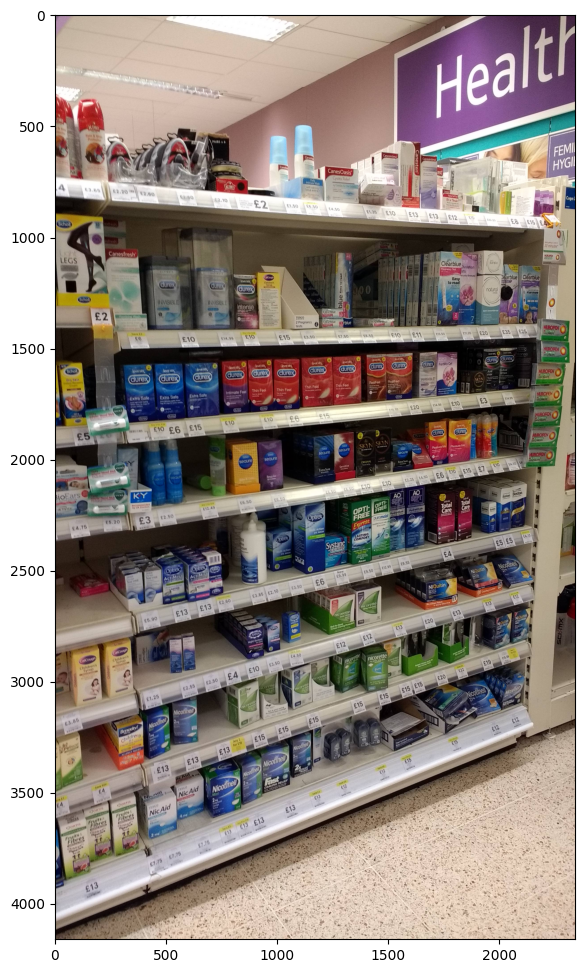

In [14]:
def display_test_image_with_annotations(image_path, predictions):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    img_width, img_height = img.shape[0], img.shape[1]

    # Add the bounding boxes
    for row in predictions:
        x1, y1, x2, y2 = row[0]*img_width, row[1]*img_height, row[2]*img_width, row[3]*img_height
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_test_image_with_annotations(img_path, predi)

# VGG16 Implementation

In [ ]:
base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the VGG16 layers

model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='bilinear'),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
history = model.fit(train_data, epochs=5, validation_data=val_data)
eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)

# ResNet50 Implementation

In [ ]:
base_model_2 = ResNet50(
    weights="imagenet",
    include_top=False, # use our own input layer for transfer learning
    input_shape=(224, 224, 3)
)

base_model_2.trainable = False

resnet_model = models.Sequential([
    Input(shape=(416, 233, 3)), 
    preprocessing.Resizing(224, 224, interpolation='bilinear'),
    base_model_2,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')  # 4 values for bounding box (x, y, width, height)
])

resnet_model.summary()  # display model details
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history = resnet_model.fit(train_data, epochs=5, validation_data=val_data)
eval_results = model.evaluate(val_data)
print("Loss on validation data:", eval_results)